## Project - Predicting Forest Fire Damage (Regularization and Non-Linear Methods) 

#### Our data comes from the Forest Fires dataset from the UCI Machine Learning Repository. This dataset contains information on fires, along with the resulting damage and associated meteorological data. We want to know how these characteristics might be useful in predicting future fire damage.

Link to the dataset - 
https://archive.ics.uci.edu/dataset/162/forest+fires 


#### The columnn descriptions are given below 


   1. X - x-axis spatial coordinate within the Montesinho park map: 1 to 9
   2. Y - y-axis spatial coordinate within the Montesinho park map: 2 to 9
   3. month - month of the year: 'jan' to 'dec' 
   4. day - day of the week: 'mon' to 'sun'
   5. FFMC - FFMC index from the FWI system: 18.7 to 96.20
   6. DMC - DMC index from the FWI system: 1.1 to 291.3 
   7. DC - DC index from the FWI system: 7.9 to 860.6 
   8. ISI - ISI index from the FWI system: 0.0 to 56.10
   9. temp - temperature in Celsius degrees: 2.2 to 33.30
   10. RH - relative humidity in %: 15.0 to 100
   11. wind - wind speed in km/h: 0.40 to 9.40 
   12. rain - outside rain in mm/m2 : 0.0 to 6.4 
   13. area - the burned area of the forest (in ha): 0.00 to 1090.84 
   (this output variable is very skewed towards 0.0, thus it may make
    sense to model with the logarithm transform).

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score



In [2]:
fires = pd.read_csv('fires.csv')
fires.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 517 entries, 0 to 516
Data columns (total 14 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  517 non-null    int64  
 1   X           517 non-null    int64  
 2   Y           517 non-null    int64  
 3   month       517 non-null    object 
 4   day         517 non-null    object 
 5   FFMC        469 non-null    float64
 6   DMC         496 non-null    float64
 7   DC          474 non-null    float64
 8   ISI         515 non-null    float64
 9   temp        496 non-null    float64
 10  RH          487 non-null    float64
 11  wind        482 non-null    float64
 12  rain        485 non-null    float64
 13  area        517 non-null    float64
dtypes: float64(9), int64(3), object(2)
memory usage: 56.7+ KB


In [3]:
fires_reference = fires[["wind", "temp", "area"]].dropna()
reference_X = fires_reference[["wind", "temp"]]

reference = LinearRegression()

In [4]:
missing_cols =[]

for col in fires.columns:
    num_na = sum(pd.isna(fires[col]))
    if num_na >0:
        missing_cols.append(col)
    print(f"The {col} column has {num_na} missing values.")

The Unnamed: 0 column has 0 missing values.
The X column has 0 missing values.
The Y column has 0 missing values.
The month column has 0 missing values.
The day column has 0 missing values.
The FFMC column has 48 missing values.
The DMC column has 21 missing values.
The DC column has 43 missing values.
The ISI column has 2 missing values.
The temp column has 21 missing values.
The RH column has 30 missing values.
The wind column has 35 missing values.
The rain column has 32 missing values.
The area column has 0 missing values.


### Data Processing

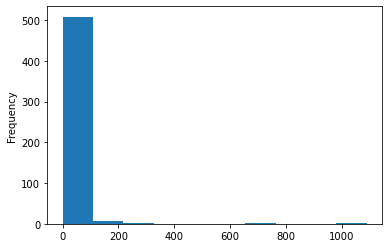

In [5]:
### Exploring the 'Area column'

fires['area'].plot.hist()
plt.show()


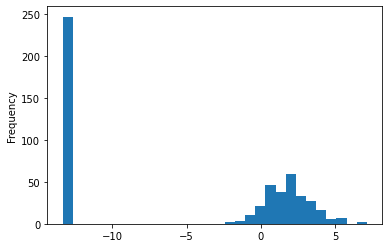

In [6]:
### Applying BoxCox transformation 

from scipy import stats

epsilon = 1e-6 ### Adding a small positive constant to handle zero values
fires['area_positive'] = fires['area'] + epsilon
fitted_data, fitted_lambda = stats.boxcox(fires['area_positive'])

pd.Series(fitted_data).plot.hist(bins = 30)
plt.show()

array([[<AxesSubplot:title={'center':'log_area'}>]], dtype=object)

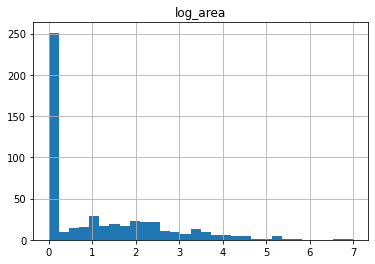

In [7]:
fires["log_area"] = np.log(fires["area"] + 1)

fires.hist("log_area", bins=30)

#### Thus we can observe that a log-normal transformation makes the data slightly more normal than the original form. We will be utilizing the same as the outcome variable, for modeling. 

In [8]:
fires[['month', 'day']].head()

,month,day
0,mar,fri
1,oct,tue
2,oct,sat
3,mar,fri
4,mar,sun


#### Instead of using month directly, we'll derive another feature called summer that takes a value of 1 when the fire occurred during the summer. The idea here is that summer months are typically hotter, so fires are more likely.

In [9]:
def is_summer_month(month):
    if month in ["jun", "jul", "aug"]:
        return 1
    else:
        return 0

fires["summer"] = fires["month"].apply(is_summer_month)

#### Imputing data from missing columns using KNN Imputer. 

In [10]:
from sklearn.impute import KNNImputer

imp_object = KNNImputer(missing_values = np.nan, n_neighbors = 3)

fires_missing = fires[missing_cols]

imputed_array = imp_object.fit_transform(fires_missing)
imputed_dataframe = pd.DataFrame(data = imputed_array, columns = missing_cols)

imputed_dataframe.head()

,FFMC,DMC,DC,ISI,temp,RH,wind,rain
0,86.2,26.200000,94.300000,5.1,16.6,51.0,6.700000,0.0
1,90.6,56.433333,669.100000,6.7,18.0,33.0,0.900000,0.0
2,90.6,43.700000,470.833333,6.7,14.6,33.0,1.300000,0.0
3,91.7,33.300000,77.500000,9.0,8.3,97.0,4.000000,0.2
4,89.3,51.300000,102.200000,9.6,11.4,99.0,4.333333,0.0


#### We'll examine the data for outliers using boxplots. 

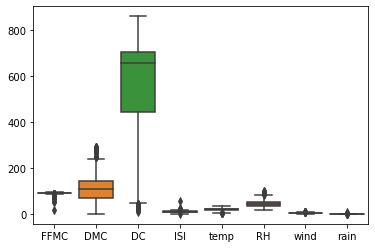

In [11]:
sns.boxplot(data = imputed_dataframe)
plt.show()

#### These dots indicate that there are outliers in the data. Let's examine the number of outliers in each of the columns. 

In [12]:

print('The number of outlier values in the given features are')
for col in missing_cols:
    
    data = imputed_dataframe[col]
    percentiles = [25,50,75]

    data_quartiles = np.percentile(data, percentiles)
    #print(data_quartiles)
    q1 = data_quartiles[0]
    q3 = data_quartiles[2] 
    iqr =q3 - q1
    upper_bound = q3 + 1.5*iqr
    lower_bound = q1 - 1.5*iqr

    outliers = (data > upper_bound) | (data < lower_bound)
    print(col, sum(outliers))


The number of outlier values in the given features are
FFMC 53
DMC 22
DC 25
ISI 23
temp 9
RH 10
wind 13
rain 8


#### We will drop the rows containing these outlier values.

In [13]:
def drop_outliers(df,col):
    data = df[col]
    percentiles = [25,50,75]

    data_quartiles = np.percentile(data, percentiles)
    #print(data_quartiles)
    q1 = data_quartiles[0]
    q3 = data_quartiles[2] 
    iqr =q3 - q1
    upper_bound = q3 + 1.5*iqr
    lower_bound = q1 - 1.5*iqr

    outliers = (data > upper_bound) | (data < lower_bound)
    print(col, sum(outliers))
    print('Original Dataframe shape', df.shape)

    outlier_indices = df[outliers].index
    imputed_data_frame_dropped = df.drop(outlier_indices)
    print('Shape of Outlier dropped dataframe', imputed_data_frame_dropped.shape)
    return imputed_data_frame_dropped    

In [14]:
imputed_dataframe.columns

Index(['FFMC', 'DMC', 'DC', 'ISI', 'temp', 'RH', 'wind', 'rain'], dtype='object')

In [15]:
imp_post_FFMC = drop_outliers(imputed_dataframe, 'FFMC')
#print(imp_post_FFMC.shape)

FFMC 53
Original Dataframe shape (517, 8)
Shape of Outlier dropped dataframe (464, 8)


In [16]:
imp_post_DMC = drop_outliers(imp_post_FFMC, 'DMC')

DMC 25
Original Dataframe shape (464, 8)
Shape of Outlier dropped dataframe (439, 8)


In [17]:
imp_post_DC = drop_outliers(imp_post_DMC, 'DC')

DC 57
Original Dataframe shape (439, 8)
Shape of Outlier dropped dataframe (382, 8)


#### Removing the outliers is reducing the size of the dataset substantially, hence for now we will not drop them and continue working with the Imputed Dataset. 

##### Standardization of the Imputed Data Set

In [18]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

standardized_imp_df = scaler.fit_transform(imputed_dataframe)


In [19]:
standardized_imp_df.std(axis = 0)

array([1., 1., 1., 1., 1., 1., 1., 1.])

In [20]:
standardized_imp_df = pd.DataFrame(data = standardized_imp_df, columns = imputed_dataframe.columns)
standardized_imp_df.head(2)

,FFMC,DMC,DC,ISI,temp,RH,wind,rain
0,-0.812283,-1.335942,-1.846711,-0.860187,-0.398187,0.418726,1.514159,-0.073268
1,-0.010735,-0.859009,0.509582,-0.508736,-0.155493,-0.715565,-1.761003,-0.073268


In [21]:
final = pd.concat([standardized_imp_df, fires['summer']], axis = 1)
final.head(2)

,FFMC,DMC,DC,ISI,temp,RH,wind,rain,summer
0,-0.812283,-1.335942,-1.846711,-0.860187,-0.398187,0.418726,1.514159,-0.073268,0
1,-0.010735,-0.859009,0.509582,-0.508736,-0.155493,-0.715565,-1.761003,-0.073268,0


#### Data Pre-Processing || Outcome Summary

#### We have carried out the below steps and it would help our ML model in the following ways : 

1. Missing Data removed via KNN imputation, which would help provide sufficient data for training the model
2. Outliers examined via BoxPlots but retained due to the high impact on the sample size
3. Standardization of the Imputed data set in order to reduce the impact of magnitude of some features.
4. Created a new feature that indicates summer months, as a forest is more likely to catch fires during summer. 

In [22]:
final_area_df = pd.concat([final, fires['area']], axis = 1)
final_area_df.head(2)

,FFMC,DMC,DC,ISI,temp,RH,wind,rain,summer,area
0,-0.812283,-1.335942,-1.846711,-0.860187,-0.398187,0.418726,1.514159,-0.073268,0,0.0
1,-0.010735,-0.859009,0.509582,-0.508736,-0.155493,-0.715565,-1.761003,-0.073268,0,0.0


### Subset selection

#### At this stage, we will try to select best features for the model, using both Forward Selection and Backward Selection

In [23]:
##Using forward selection

model = LinearRegression()

for i in list(range(2,9)):
    X = final
    y = fires['log_area']

    sfs_fwd = SequentialFeatureSelector(estimator = model, 
                                   n_features_to_select = i,
                                   direction = 'forward')
    sfs_fwd.fit(X,y)
    selected_features = sfs_fwd.get_feature_names_out()

    lm = LinearRegression()
    X = X[selected_features]
    X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2, random_state = 763)
    lm.fit(X_train,y_train)
    predictions = lm.predict(X_test)
    mse = mean_squared_error(y_test, predictions)
    
    
    lm = LinearRegression()
    cv_score = cross_val_score(lm,X,y,cv = 5, scoring = 'neg_mean_squared_error')
    print('The MSE with Fwd selection for n_features= ', i, 'is', mse)
    print('The CV score for n_features =', i, 'is', np.mean(cv_score))
    print('The Features are', selected_features)

The MSE with Fwd selection for n_features=  2 is 2.19138744513824
The CV score for n_features = 2 is -2.1735431721198535
The Features are ['FFMC' 'DC']
The MSE with Fwd selection for n_features=  3 is 2.175564365986747
The CV score for n_features = 3 is -2.173227096397195
The Features are ['FFMC' 'DC' 'wind']
The MSE with Fwd selection for n_features=  4 is 2.181261861787522
The CV score for n_features = 4 is -2.193528106772711
The Features are ['FFMC' 'DC' 'RH' 'wind']
The MSE with Fwd selection for n_features=  5 is 2.2365464027569715
The CV score for n_features = 5 is -2.199428658923486
The Features are ['FFMC' 'DC' 'ISI' 'RH' 'wind']
The MSE with Fwd selection for n_features=  6 is 2.2285035728461606
The CV score for n_features = 6 is -2.239722553934875
The Features are ['FFMC' 'DC' 'ISI' 'RH' 'wind' 'summer']
The MSE with Fwd selection for n_features=  7 is 2.2712591722246063
The CV score for n_features = 7 is -2.2783208387124594
The Features are ['FFMC' 'DMC' 'DC' 'ISI' 'RH' 'win

In [24]:
##Using backward selection

from sklearn.model_selection import cross_val_score

for i in list(range(2,9)):
    X = final
    y = fires['log_area']

    sfs_fwd = SequentialFeatureSelector(estimator = model, 
                                   n_features_to_select = i,
                                   direction = 'backward')
    sfs_fwd.fit(X,y)
    selected_features = sfs_fwd.get_feature_names_out()

    lm = LinearRegression()
    X = X[selected_features]
    X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2, random_state = 763)
    lm.fit(X_train,y_train)
    predictions = lm.predict(X_test)
    mse = mean_squared_error(y_test, predictions)
    
    lm = LinearRegression()
    cv_score = cross_val_score(lm,X,y,cv = 5, scoring = 'neg_mean_squared_error')
    print('The MSE with Bwd selection for n_features= ', i, 'is', mse)
    print('The CV score for n_features =', i, 'is', np.mean(cv_score))
    print('The Features are', selected_features)

The MSE with Bwd selection for n_features=  2 is 2.156001020453709
The CV score for n_features = 2 is -2.173357302739327
The Features are ['DC' 'wind']
The MSE with Bwd selection for n_features=  3 is 2.175564365986747
The CV score for n_features = 3 is -2.173227096397195
The Features are ['FFMC' 'DC' 'wind']
The MSE with Bwd selection for n_features=  4 is 2.181261861787522
The CV score for n_features = 4 is -2.193528106772711
The Features are ['FFMC' 'DC' 'RH' 'wind']
The MSE with Bwd selection for n_features=  5 is 2.2365464027569715
The CV score for n_features = 5 is -2.199428658923486
The Features are ['FFMC' 'DC' 'ISI' 'RH' 'wind']
The MSE with Bwd selection for n_features=  6 is 2.2285035728461606
The CV score for n_features = 6 is -2.239722553934875
The Features are ['FFMC' 'DC' 'ISI' 'RH' 'wind' 'summer']
The MSE with Bwd selection for n_features=  7 is 2.2712591722246063
The CV score for n_features = 7 is -2.2783208387124594
The Features are ['FFMC' 'DMC' 'DC' 'ISI' 'RH' 'win

#### The MSE in minimum for 2 features in Backward Selection and for 3 features in Forward Selection. To be one the safe side, we will go with 3 features, as they are common in both Forward and Backward Selection.  The Features are ['FFMC' 'DC' 'wind']

In [25]:
fwd3_model = LinearRegression()

X = final[['FFMC', 'DC', 'wind']]
y = fires['log_area']

fwd3_model.fit(X,y)

LinearRegression()

### Developing Candidate Models - Lasso, Ridge and Splines

In [26]:
### Lasso

X = final
y = fires['log_area']

from sklearn.linear_model import LassoCV

lasso = LassoCV(alphas = np.linspace(1,10000,1000))
lasso.fit(X,y)

print('Lasso alpha', lasso.alpha_)
print('Lasso features', lasso.coef_)

Lasso alpha 10000.0
Lasso features [ 0.  0.  0. -0.  0. -0.  0.  0. -0.]


In [27]:
###Ridge
from sklearn.linear_model import RidgeCV

ridge = RidgeCV(alphas = np.linspace(1,10000,1000))
ridge.fit(X,y)

print('Ridge alpha', ridge.alpha_)
print('Ridge features', ridge.coef_)

Ridge alpha 1372.2342342342342
Ridge features [ 0.01311215  0.02006457  0.02004741 -0.01073465  0.01297049 -0.01489714
  0.02670554  0.00816103 -0.01455017]


#### Since the Lasso alpha parameter is on the extreme and also the Lasso outcome suggests not to have any features at all, we will continue working with the Ridge model and further tune the alpha. 

In [28]:
ridge = RidgeCV(alphas = np.linspace(1000,1500,100))
ridge.fit(X,y)

print('Ridge alpha', ridge.alpha_)
print('Ridge features', ridge.coef_)

Ridge alpha 1373.7373737373737
Ridge features [ 0.01310398  0.02005012  0.02003371 -0.01072164  0.01296282 -0.01488602
  0.02668217  0.00815492 -0.01453406]


#### We will use this value of the Ridge tuning parameter in the k-fold cross validation. 

In [29]:
### Splines

from sklearn.preprocessing import SplineTransformer

n_knots_range = list(range(2,10))

for i in n_knots_range:
    spline =  SplineTransformer(degree = 3, n_knots = i, knots = 'quantile')
    spline_X = spline.fit_transform(X)

    lm_spline = LinearRegression()

    X_train, X_test, y_train, y_test = train_test_split(spline_X,y, test_size = 0.2, random_state = 763)
    lm_spline.fit(X_train,y_train)

    predictions = lm_spline.predict(X_test)
    mse = mean_squared_error(y_test, predictions)
    print('The MSE with Spline for', i, 'knots is', mse)

The MSE with Spline for 2 knots is 2.210193141228603
The MSE with Spline for 3 knots is 2.170665016271733
The MSE with Spline for 4 knots is 2.268746538030937
The MSE with Spline for 5 knots is 2.4012950035812413
The MSE with Spline for 6 knots is 2.405202745072192
The MSE with Spline for 7 knots is 2.5369081840862675
The MSE with Spline for 8 knots is 2.6626518211542822
The MSE with Spline for 9 knots is 2.615470069703814


#### Thus, we can see that we get the minimum MSE as 2.17 for a Cubic spline with 3 knots. This will be added to our Candidate Models list. 

In [30]:
spline =  SplineTransformer(degree = 3, n_knots = 3, knots = 'quantile')
spline_X = spline.fit_transform(X)

lm_spline = LinearRegression()

X_train, X_test, y_train, y_test = train_test_split(spline_X,y, test_size = 0.2, random_state = 763)
lm_spline.fit(X_train,y_train)

predictions = lm_spline.predict(X_test)
mse = mean_squared_error(y_test, predictions)
print('The MSE with Spline for 3 knots is', mse)

The MSE with Spline for 3 knots is 2.170665016271733


### Comparing Candidate models using K-fold cross validation

In [31]:
from sklearn.model_selection import cross_val_score

fwd3_model = LinearRegression()

X = final[['FFMC', 'DC', 'wind']]
y = fires['log_area']

fwd3_model_cv_score = cross_val_score(fwd3_model, X, y, cv = 5, scoring = 'neg_mean_squared_error')
print('The CV score for fwd3 model is', np.mean(fwd3_model_cv_score))


##


The CV score for fwd3 model is -2.173227096397195


In [32]:
X = final
y = fires['log_area']

ridge_model_cv_score = cross_val_score(ridge, X, y, cv = 5, scoring = 'neg_mean_squared_error')
print('The CV score for the Ridge model is', np.mean(ridge_model_cv_score))

The CV score for the Ridge model is -2.196754531261845


In [33]:
spline =  SplineTransformer(degree = 3, n_knots = 3, knots = 'quantile')

lm_spline = LinearRegression()
spline_X = spline.fit_transform(X)

lm_spline = LinearRegression()

spline_model_cv_score = cross_val_score(lm_spline, spline_X, y, cv = 5, scoring = 'neg_mean_squared_error')
print('The CV score for the Spline based model is', np.mean(spline_model_cv_score))


The CV score for the Spline based model is -15.883183408237993


In [34]:
fires_reference = final[["wind", "temp"]].dropna()
reference_X = fires_reference[["wind", "temp"]]
reference_y = fires['log_area']

reference_lm = LinearRegression()

ref_model_cv_score = cross_val_score(reference_lm, reference_X, reference_y, cv = 5, scoring = 'neg_mean_squared_error')
print('The CV score for the Reference model is', np.mean(ref_model_cv_score))

The CV score for the Reference model is -2.204650013004116


C:\Users\NageshN\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


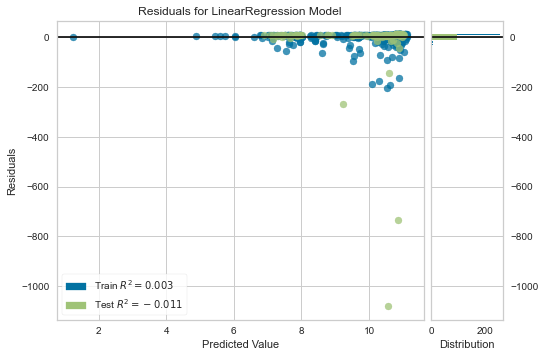

<AxesSubplot:title={'center':'Residuals for LinearRegression Model'}, xlabel='Predicted Value', ylabel='Residuals'>

In [35]:
#### Plotting the Forward Selection model

fwd3_model = LinearRegression()

X = final[['FFMC', 'DC', 'wind']]
y = fires['area']

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2, random_state = 763)

fwd3_model.fit(X_train,y_train)

predictions =  fwd3_model.predict(X_test)
residuals = y_test - predictions
actuals = y_test

from yellowbrick.regressor import ResidualsPlot

visualizer = ResidualsPlot(fwd3_model)
visualizer.fit(X_train, y_train)  
visualizer.score(X_test, y_test) 
visualizer.show()  # Display the plot

#### These Residual plot indicates that a non-linear model may have been a better fit, but we had rejected the Splines based model due to its low Cross validation score. 

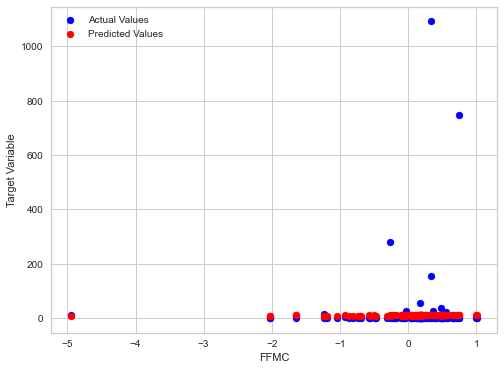

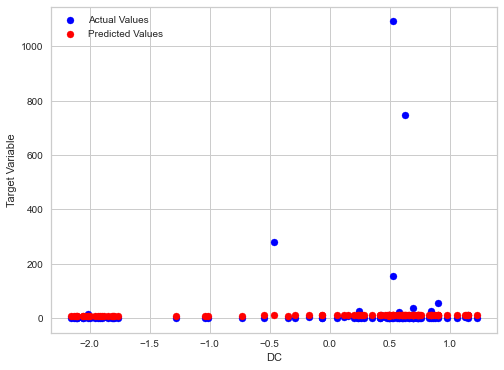

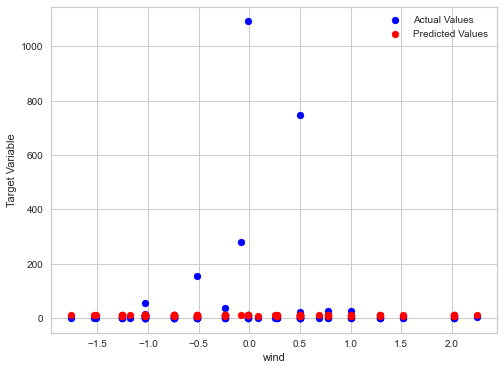

In [36]:
import matplotlib.pyplot as plt

# Assuming you have fitted your linear regression model to 'lm'
predictions = fwd3_model.predict(X_test)
actuals = y_test

for feature in X_test.columns:
    plt.figure(figsize=(8, 6))
    plt.scatter(X_test[feature], actuals, color='blue', label='Actual Values')
    plt.scatter(X_test[feature], predictions, color='red', label='Predicted Values')
    plt.xlabel(feature)
    plt.ylabel('Target Variable')
    plt.legend()
    plt.show()


#### These visualizations depict model performance. We can see that many of the predictions are close to the actual values, for different features. 

### Conclusion

#### Out of the four models (including the reference model), the best performance is given by the Forward Selection with 3 features which are 'FFMC' , 'DC' and 'wind'. However, note that this is on the log-scale, so this suggests that the predictions are off by a magnitude of about 2. On the surface, this suggests that the models overall are not good predictors.

#### However, this problem is known to be a difficult one. The extreme skew in the outcome hurts many of the assumptions needed by linear models. We hope that this showcases that machine learning is not a universal fix. Several problems have characteristics that make prediction difficult.


### Thanks !